In [1]:
import os 

os.chdir("/home/theovincent/MVA/3DPointCloud/3DPointCloudClassification")

# Pipeline to create the dataset

In [2]:
dataset_name = "MiniLille2_split1"
full_dataset_name = f"{dataset_name}_with_features"
is_train_data = True
seed = 1

## Load the dataset

In [3]:
import numpy as np 

from classifier_3D.utils.path import get_data_path
from classifier_3D.utils.ply_file import read_ply

dataset_path = get_data_path(full_dataset_name, is_train_data)
dataset, _ = read_ply(dataset_path)
points = np.vstack((dataset["x"], dataset["y"], dataset["z"])).T.astype(np.float32)

## Pick a center

In [4]:
from range_net import CENTERS, Z_GROUNDS, Z_GROUND


centers_bound = CENTERS[dataset_name]

weights = np.random.randint(0, 10, size=4).astype(float)
weights /= weights.sum()

center = np.append(weights @ centers_bound, [Z_GROUNDS[dataset_name] - Z_GROUND])

### Visualise the center

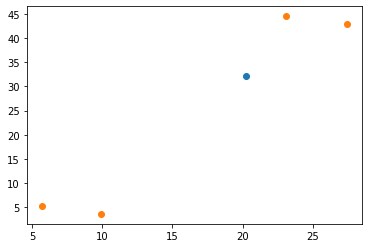

In [5]:
import matplotlib.pyplot as plt


plt.scatter(center[0], center[1])
_ = plt.scatter(centers_bound[:, 0], centers_bound[:, 1])

## Rotate the dataset

In [6]:
from range_net import ROTATIONS

theta = -ROTATIONS[dataset_name]

rotation = np.array([[np.cos(theta), - np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

### Visualise the rotation on the center points

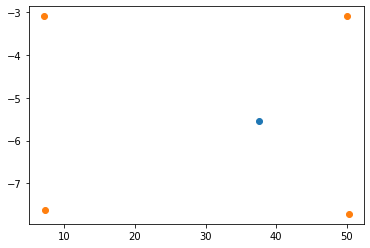

In [7]:
import matplotlib.pyplot as plt

rotated_center = center @ rotation.T
rotated_centers_bound = np.hstack((centers_bound, np.ones((centers_bound.shape[0], 1)))) @ rotation.T

plt.scatter(rotated_center[0], rotated_center[1])
_ = plt.scatter(rotated_centers_bound[:, 0], rotated_centers_bound[:, 1])

## Translate the dataset

In [8]:
centered_rotated_points = (points - np.expand_dims(center, axis=0)) @ rotation.T

## Clip points that are too far, too high and too close and sample

In [10]:
from range_net import MAX_DISTANCE, MAX_HEIGHT, MIN_DISTANCE, N_POINTS, BINS, N_PER_BINS

ranges = np.linalg.norm(centered_rotated_points, axis=1)
ranges_x_y = np.linalg.norm(centered_rotated_points[:, 0:2], axis=1)
geometrically_fitting = np.logical_and(np.logical_and(ranges < MAX_DISTANCE, centered_rotated_points[:, 2] < MAX_HEIGHT), ranges_x_y > MIN_DISTANCE)

if geometrically_fitting.sum() > N_POINTS:
    to_keep = np.zeros(points.shape[0], dtype=bool)

    for idx_bin in range(len(BINS) - 1):
        indexes_in_bin = np.logical_and(
            np.logical_and(ranges > BINS[idx_bin], ranges < BINS[idx_bin + 1]),
            geometrically_fitting,
        )
        if indexes_in_bin.sum() < N_PER_BINS[idx_bin]:
            to_keep[indexes_in_bin] = True
        else:
            to_keep[
                np.random.choice(
                    np.nonzero(indexes_in_bin)[0],
                    size=N_PER_BINS[idx_bin],
                    replace=False,
                )
            ] = True
else:
    to_keep = geometrically_fitting
    
clipped_points = centered_rotated_points[to_keep]

## Save the point cloud

In [11]:
from classifier_3D.utils.ply_file import write_ply

# For cloud compare
write_ply("data/creation.ply", clipped_points, ["x", "y", "z"])

# For lidar-bonnetal
bin_points = np.hstack((clipped_points, np.zeros((clipped_points.shape[0], 1)))).astype(np.float32)
_ = bin_points.tofile(f"data/{dataset_name}_sample.bin")

## Visualize projection

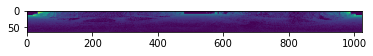

In [12]:
from range_net.laserscan import LaserScan

laser_scan = LaserScan(project=True)

laser_scan.open_scan(f"data/{dataset_name}_sample.bin")

_ = plt.imshow(laser_scan.proj_range)